For EDA please visit https://www.kaggle.com/rohitsingh9990/m5-forecasting-eda-feature-engineering

In [3]:
# The objective of this task is to forecast the unit sales of the next 28 days.
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import *
import gc
import joblib
import tqdm
import warnings
warnings.filterwarnings('ignore')


## 1. Loading Data

In [2]:
INPUT_DIR_PATH = 'input/'

In [3]:
# Downcast storage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: # Downcast each column
        col_type = df[col].dtypes
        if col_type in numerics: # Based on min and max, change the varible type.
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Read Data
def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_evaluation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df
    

In [4]:
sell_prices_df, calendar_df, sales_train_validation_df, submission_df = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1947 columns


In [5]:
sales_train_validation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1

In [6]:
# 不同的商品种类一共有3049种
sales_train_validation_df['item_id'].nunique()

3049

In [7]:
# 记录的数据中一共有10个地域
NUM_ITEMS = sales_train_validation_df.shape[0]  # 30490
DAYS_PRED = 28
nrows = int(365 * 2) * NUM_ITEMS

In [8]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        # 对非数值数据进行编码处理
        le = preprocessing.LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df

calendar_df = encode_categorical(calendar_df, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]).pipe(reduce_mem_usage)
# sales_train_validation_df = encode_categorical(sales_train_validation_df, ["item_id", "dept_id", "cat_id", "store_id", "state_id"]).pipe(reduce_mem_usage)
# sell_prices_df = encode_categorical(sell_prices_df, ["item_id", "store_id"]).pipe(reduce_mem_usage)

Mem. usage decreased to  0.08 Mb (36.9% reduction)


In [9]:
# get product table
# sales_train_validation_df = sales_train_validation_df[['id','item_id','dept_id','cat_id','store_id','state_id'] + ['d_' + str(i) for i in range(1000,1914)]]

product = sales_train_validation_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

## 2. Merging dataframes

In [10]:
# function to read the data and merge it
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data（溶化数据，即非 id_vars 的特征进行行列转置）
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    sales_train_validation = sales_train_validation.iloc[-nrows:,:]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # 将列的名字改变成与训练数据相接的后 28 天日期
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # 和 product table合并
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    sales_train_validation['part'] = 'train'
    test2['part'] = 'test2' # 这一部分数据用于预测
    
    # 将溶化后的数据进行按行合并
    data = pd.concat([sales_train_validation,test2], axis = 0)
    
    del sales_train_validation, test2
    
    print(data.shape)
    
    # 删除多余的日历特征
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [11]:
# nrows = 365 * 2 * NUM_ITEMS
data = melt_and_merge(calendar_df, sell_prices_df, sales_train_validation_df, submission_df, nrows = nrows, merge = True)
# nrows = 27500000

Melted sales train validation has 59181090 rows and 8 columns
Mem. usage decreased to 3273.49 Mb (9.4% reduction)
(23111420, 9)
Our final dataset to train has 23111420 rows and 19 columns


In [12]:
# np.c_和np.r_的用法解析:
# np.r_是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等。
# np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等。

# 初始化权重矩阵，np.identity返回的是nxn的主对角线为1，其余地方为0的数组
weight_mat = np.c_[np.identity(NUM_ITEMS).astype(np.int8), #item :level 12
                   np.ones([NUM_ITEMS,1]).astype(np.int8), # level 1
                   pd.get_dummies(product.state_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.item_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str),drop_first=False).astype('int8').values
                   ].T

from scipy.sparse import csr_matrix

# 把一个稀疏的 weight_mat (np.array)压缩
weight_mat_csr = csr_matrix(weight_mat)
del weight_mat; gc.collect()


0

In [13]:

def weight_calc(data,product):

    # 计算RMSSE的分母，并根据销售额计算权重，weight1 是RMSSE的分母，weight2为权重。
    # 为私人Lb进行更改
    sales_train_val = pd.read_csv('input/sales_train_evaluation.csv')
    d_name = ['d_' + str(i+1) for i in range(1941)]
    sales_train_val = weight_mat_csr * sales_train_val[d_name].values
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1,1942),(weight_mat_csr.shape[0],1)))
    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1
    weight1 = np.sum((np.diff(sales_train_val,axis=1)**2),axis=1)/(1941-start_no) # 1913+28
    df_tmp = data[(data['date'] > '2016-04-24') & (data['date'] <= '2016-05-22')] # change date for weights calculation
    df_tmp['amount'] = df_tmp['demand'] * df_tmp['sell_price']
    df_tmp =df_tmp.groupby(['id'])['amount'].apply(np.sum).values
    weight2 = weight_mat_csr * df_tmp 
    weight2 = weight2/np.sum(weight2)
    del sales_train_val
    gc.collect()
    return weight1, weight2

In [14]:
weight1, weight2 = weight_calc(data,product)


In [16]:
weight2.shape

(42840,)

In [17]:
weights = pd.read_csv('weight_scale_1914.csv')


In [18]:
# 'Level3'代表'store_id'
B = weights[weights['Level_id'] == 'Level3'][['Agg_Level_1','weight']].set_index('Agg_Level_1')
dictionary1 = {}
for ind, key in enumerate(B.index):
    dictionary1[key] = B['weight'][ind]

In [19]:
# 'Level2'代表'state_id'
A = weights[weights['Level_id'] == 'Level2'][['Agg_Level_1','weight']].set_index('Agg_Level_1')
dictionary = {}
for ind, key in enumerate(A.index):
    dictionary[key] = A['weight'][ind]

In [20]:
########## adding weights #############
# weights = pd.read_csv('weights.csv')
# weights['series'] = weights['series'].apply(lambda x: x.replace("--","_"))
# weights.index = weights.series
# weights.drop('series',axis=1,inplace = True)
# weight = weights.to_dict()['weight']
# data['item_store'] = data['item_id'] +"_" + data['store_id']

# 计算权重
data['weight'] = data['state_id'].map(dictionary) + data['store_id'].map(dictionary1)

# data['weight'] = data['item_id'].map(weight) + data['dept_id'].map(weight) + \
# data['cat_id'].map(weight) +data['store_id'].map(weight) +data['state_id'].map(weight) + data['item_store'].map(weight)


In [21]:
def add_demand_features(feature_set,df):
    # 将"demand"特征滑动 shift 大小的窗口作为新的特征
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        df["_".join(feature_set) + "_" + f"shift_t{shift}"] = df.groupby(feature_set)["demand"].transform(
            lambda x: x.shift(shift)
        )
    # 将"demand"特征滑动 DAYS_PRED 个窗口大小后的值再滑动 size 大小的窗口，计算窗口内方差作为新的特征，下同
    for size in [7, 15, 50, 30, 21, 60,90,180]:
        df["_".join(feature_set) + "_" + f"rolling_std_t{size}"] = df.groupby(feature_set)["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(size).std()
        )

    for size in [7, 15, 50, 30, 21, 60, 90, 180]:
        df["_".join(feature_set) + "_" + f"rolling_mean_t{size}"] = df.groupby(feature_set)["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(size).mean()
        )
    # .skew() 表示计算偏度
    df["_".join(feature_set) + "_" + "rolling_skew_t30"] = df.groupby(feature_set)["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).skew()
    )
    # .kurt()表示计算峰度
    df["_".join(feature_set) + "_" + "rolling_kurt_t30"] = df.groupby(feature_set)["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).kurt()
    )
    return df

In [23]:
def transform(data):
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']+['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    
    # 对非数值特征进行编码
    for feature in cat:
        try:
            encoder = preprocessing.LabelEncoder()
            data[feature] = encoder.fit_transform(data[feature])
        except:
            data[feature] = data[feature].apply(lambda x: str(x))
            encoder = preprocessing.LabelEncoder()
            data[feature] = encoder.fit_transform(data[feature])
#     for feature in cat:
#         data[feature] = data[feature].astype('category')
            
    return data

def simple_fe(data):
#     data['snap'] = data[['snap_CA','snap_TX','snap_WI']].sum(axis=1)
#     data['snap_b'] = data['snap'].apply(lambda x: 1 if x!=0 else 0)
      # time features
    data['date'] = pd.to_datetime(data['date'])
    attrs = ["year", "quarter", "month", "week", "day", "dayofweek", "is_year_end", "is_year_start", "is_quarter_end", \
        "is_quarter_start", "is_month_end","is_month_start",
    ]
    
    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        data[attr] = getattr(data['date'].dt, attr).astype(dtype)
    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(np.int8)
#     data['sell_price'].fillna(0,inplace = True)
    data = add_demand_features(['id'],data).pipe(reduce_mem_usage)
#     data = add_demand_features(['id','is_weekend'],data).pipe(reduce_mem_usage)
    data = add_demand_features(['id','store_id'],data).pipe(reduce_mem_usage)
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    
    # 后一天较前一天的价格变化率
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    
    # 后一年最高价格较当天价格的变化率
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
#     data['rolling_price_max_t180'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(180).max())
#     data['price_change_t180'] = (data['rolling_price_max_t180'] - data['sell_price']) / (data['rolling_price_max_t180'])
#     data['rolling_price_max_t90'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(90).max())
#     data['price_change_t90'] = (data['rolling_price_max_t90'] - data['sell_price']) / (data['rolling_price_max_t90'])
    
    # 计算滑动一周/一个月的价格的方差
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    return data


In [22]:
def add_sell_features(feature_set,df):
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        df["_".join(feature_set) + "_price_" + f"shift_t{shift}"] = df.groupby(feature_set)["sell_price"].transform(
            lambda x: x.shift(shift)
        )

    for size in [7, 15, 50, 30, 21, 60,90,180]:
        df["_".join(feature_set) + "_price_" + f"rolling_std_t{size}"] = df.groupby(feature_set)["sell_price"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(size).std()
        )

    for size in [7, 15, 50, 30, 21, 60, 90, 180]:
        df["_".join(feature_set) + "_price_" + f"rolling_mean_t{size}"] = df.groupby(feature_set)["sell_price"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(size).mean()
        )

    df["_".join(feature_set) + "_price_" + "rolling_skew_t30"] = df.groupby(feature_set)["sell_price"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).skew()
    )
    df["_".join(feature_set) + "_price_" + "rolling_kurt_t30"] = df.groupby(feature_set)["sell_price"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).kurt()
    )
    return df

In [24]:
# def wrmsse(preds, data):
    
#     # 正确的标签
#     y_true = data.get_label()
#     y_true = y_true.values
#     # number of columns
#     num_col = len(y_true)//NUM_ITEMS
    
#     # 由于推断的结果是一维数组，请对其进行修复。
#     reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
#     reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
    
#     x_name = ['pred_' + str(i) for i in range(num_col)]
#     x_name2 = ["act_" + str(i) for i in range(num_col)]
          
#     train = np.array(weight_mat_csr*np.c_[reshaped_preds, reshaped_true])
    
#     score = np.sum(
#                 np.sqrt(
#                     np.mean(
#                         np.square(
#                             train[:,:num_col] - train[:,num_col:])
#                         ,axis=1) / weight1) * weight2)
    
#     return 'wrmsse', score, False


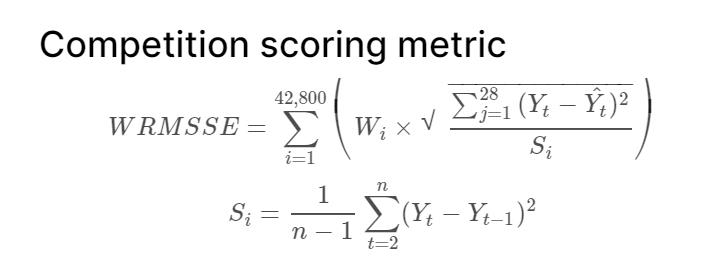

In [7]:
# WRMSSE是本次比赛所使用的的评价指标
from IPython.display import Image
Image(filename = 'D:/1.jpg', width=800, height=600)

In [25]:
def eval_wrmsse(preds, y_true):
    
    # 正确的标签
#     y_true = data.get_label()
    y_true = y_true.values
    # number of columns
    num_col = len(y_true)//NUM_ITEMS
    
    #  由于推断的结果是一维数组，请对其进行修复。
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
    
    x_name = ['pred_' + str(i) for i in range(num_col)]
    x_name2 = ["act_" + str(i) for i in range(num_col)]
          
    train = np.array(weight_mat_csr*np.c_[reshaped_preds, reshaped_true])
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return score


In [26]:
# 经过之前特征工程后所包含的所有特征
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    "id_shift_t28",
    "id_shift_t29",
    "id_shift_t30",
    'id_store_id_shift_t28',
 'id_store_id_shift_t29',
 'id_store_id_shift_t30',
    'id_store_id_rolling_std_t7',
 'id_store_id_rolling_std_t30',
 'id_store_id_rolling_std_t180',
 'id_store_id_rolling_mean_t7',
 'id_store_id_rolling_mean_t30',
 'id_store_id_rolling_mean_t180',
 'id_store_id_rolling_skew_t30',
 'id_store_id_rolling_kurt_t30',
    "id_rolling_std_t7",
    "id_rolling_std_t30",
    "id_rolling_std_t60",
    "id_rolling_std_t90",
    "id_rolling_std_t180",
    "id_rolling_mean_t7",
    "id_rolling_mean_t30",
    "id_rolling_mean_t60",
    "id_rolling_mean_t90",
    "id_rolling_mean_t180",
    "id_rolling_skew_t30",
    "id_rolling_kurt_t30",
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_month_end",
    "is_month_start",
    "is_weekend",
    'id_rolling_std_t21',
 'id_rolling_mean_t21',
 'id_store_id_rolling_std_t60',
 'id_store_id_rolling_std_t90',
 'id_store_id_rolling_mean_t60',
 'id_store_id_rolling_mean_t90']

In [27]:
categorical_features = ['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',]

In [28]:
# #### frequency encoder ######
for feature in categorical_features:
    if feature not in ['item_id','store_id','event_name_2','event_type_2']:
        dict_ = dict(data[feature].value_counts())
#         features.append(feature + "_count")
#         data[feature + "_count"] = data[feature].map(dict_)

In [29]:
from datetime import datetime, timedelta

# 模型代码
def run_lgb(data, wrmsse):
    feature_importance = pd.DataFrame()
    
    mask1 = data['date']<= '2016-04-24'
    mask2 = data['date']> data['date'].min() + timedelta(208)
    mask = mask1&mask2
    x_train = data[mask]
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-04-24') & (data['date'] <= '2016-05-22')]
    y_val = x_val['demand']
    test = data[(data['date'] >=  (datetime(2016,5,23) - timedelta(100)))]
    test = test.reset_index(drop = True)
    keep_cols = [col for col in test if '_tmp_' not in col]
    test[keep_cols].to_pickle('input/test/test_data_private.pkl')

    gc.collect()
    params = {
                'boosting_type': 'gbdt',
                'objective': 'tweedie',
                'tweedie_variance_power': 1.1,
                'metric': 'rmse',
                'subsample': 0.5,
                'subsample_freq': 1,
                'learning_rate': 0.03,
                'num_leaves': 2**11-1,
                'min_data_in_leaf': 2**12-1,
                'feature_fraction': 0.5,
                'max_bin': 100,
#                     'n_estimators': 1400,
                'boost_from_average': False,
                'seed':1992,
                'n_jobs':-1,
                'verbose': 1,
            } 

    train_set = lgb.Dataset(x_train[features], label = y_train, weight = x_train['weight'])
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train
    
    model = lgb.train(params, train_set, num_boost_round = 20000, early_stopping_rounds = 500, 
                      valid_sets = [train_set, val_set], verbose_eval = 100, feval = wrmsse)
    # 模型保存
    joblib.dump(model, 'input/models/lgbm_private_0.482_public.sav')
    feature_importance['feature'] = features
    feature_importance['importance'] = model.feature_importance('gain')
    val_pred = np.clip(model.predict(x_val[features]),0, None)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    wrmsse_score = eval_wrmsse(val_pred, y_val)
    print(f'Our val rmse score is {val_score}')
    print(f'Our val wrmsse score is {wrmsse_score}')
    return wrmsse_score, val_score, feature_importance


In [30]:
data = transform(data)

In [31]:
data = simple_fe(data)
data = reduce_mem_usage(data)

Mem. usage decreased to 2402.44 Mb (60.1% reduction)
Mem. usage decreased to 3328.16 Mb (45.5% reduction)
Mem. usage decreased to 3504.48 Mb (0.0% reduction)


In [32]:
TARGET = 'demand'
for d_shift in [1,2,3,4,5,6,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        features.append(col_name)
        data[col_name] = data.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
        

Shifting period: 1
Shifting period: 2
Shifting period: 3
Shifting period: 4
Shifting period: 5
Shifting period: 6
Shifting period: 7
Shifting period: 14


In [33]:
import re
import joblib
ID_stationarity = joblib.load('input/test/ADF_values.pkl')
stationarity = {re.sub('_validation','_evaluation',k):ID_stationarity[k] for k in ID_stationarity}
data['ADF'] = data['id'].map(stationarity)
data['ADF'] = data['ADF'].apply(lambda x: x[0])
features.append('ADF')

In [34]:
features = [f for f in features if 'count' not in f]

In [35]:
len(features)

92

In [36]:
%%time
wrmsse_score, val_score, feature_importance = run_lgb(data, wrmsse)

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.09956	training's wrmsse: 0.616345	valid_1's rmse: 2.00886	valid_1's wrmsse: 0.600455
[200]	training's rmse: 2.04695	training's wrmsse: 0.48492	valid_1's rmse: 1.9749	valid_1's wrmsse: 0.5069
[300]	training's rmse: 2.02603	training's wrmsse: 0.441164	valid_1's rmse: 1.96675	valid_1's wrmsse: 0.495198
[400]	training's rmse: 2.01382	training's wrmsse: 0.425763	valid_1's rmse: 1.96324	valid_1's wrmsse: 0.493084
[500]	training's rmse: 2.00369	training's wrmsse: 0.415422	valid_1's rmse: 1.96025	valid_1's wrmsse: 0.491965
[600]	training's rmse: 1.99546	training's wrmsse: 0.409564	valid_1's rmse: 1.9585	valid_1's wrmsse: 0.492117
[700]	training's rmse: 1.98806	training's wrmsse: 0.404592	valid_1's rmse: 1.95709	valid_1's wrmsse: 0.493056
[800]	training's rmse: 1.98121	training's wrmsse: 0.400914	valid_1's rmse: 1.95571	valid_1's wrmsse: 0.493229
[900]	training's rmse: 1.97446	training's wrmsse: 0.3975	valid

In [37]:
feature_importance.sort_values(by = 'importance',ascending = False, inplace = True)

In [38]:
feature_importance['feature'].head(10).values

array(['rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_7',
       'rolling_mean_tmp_1_30', 'rolling_mean_tmp_2_14',
       'rolling_mean_tmp_1_60', 'rolling_mean_tmp_2_30',
       'rolling_mean_tmp_2_7', 'dayofweek',
       'id_store_id_rolling_mean_t180', 'rolling_mean_tmp_3_7'],
      dtype=object)

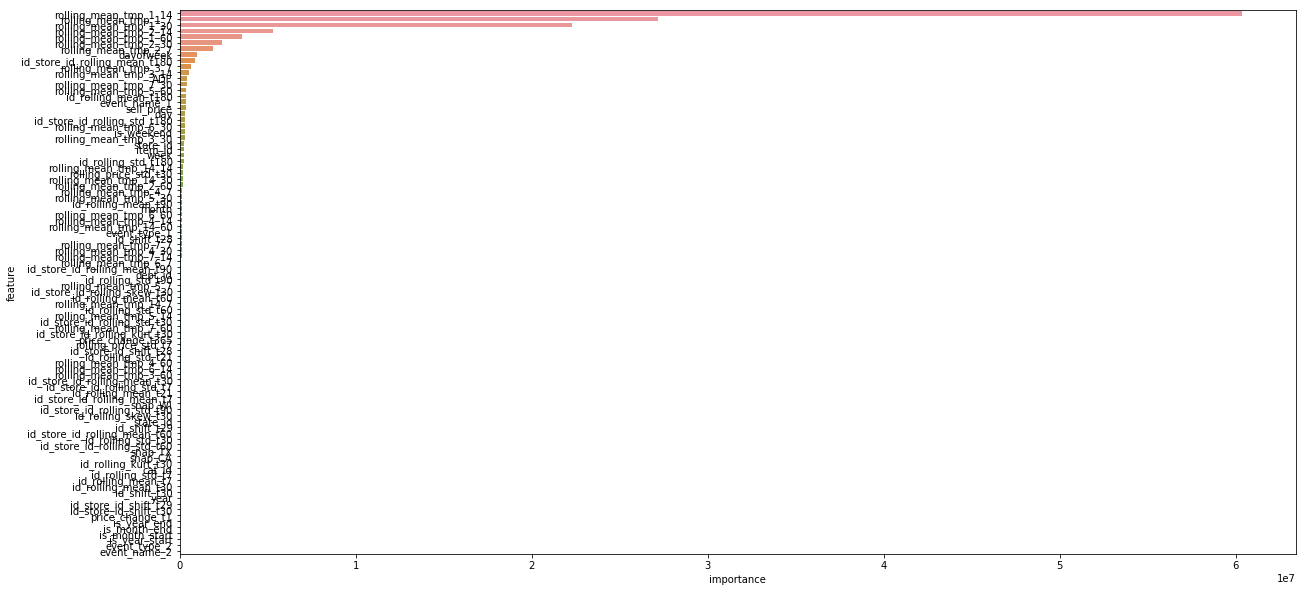

In [39]:
plt.figure(figsize = (20,10))
sns.barplot(x = feature_importance['importance'], y = feature_importance['feature'])

## daywise prediction

In [40]:
ROLS_SPLIT = []
for i in [1,2,3,4,5,6,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [41]:
END_TRAIN = datetime(2016,5,22)
TARGET = 'demand'

def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','date',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]


In [42]:
########################### Predict
#################################################################################
import time
from IPython.display import clear_output
# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = pd.read_pickle('input/test/test_data_private.pkl')

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    temp_df = pd.DataFrame()
    for j, i in enumerate(ROLS_SPLIT):
        print('iteration :{}'.format(j))
        clear_output(wait = True)
        temp_df = pd.concat([temp_df, make_lag_roll(i)],axis = 1)
    print(temp_df.shape)    
    grid_df = pd.concat([grid_df, temp_df], axis = 1)
    print('start')
    model_path = 'input/models/lgbm_private_0.482_public.sav'
    estimator = joblib.load(model_path)
    day_mask = base_test['date']==(END_TRAIN + timedelta(PREDICT_DAY))
    pred = estimator.predict(grid_df[day_mask][features])
    base_test[TARGET][day_mask] = list(pred)
    print(pred)
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
#     temp_df[TARGET] = temp_df[TARGET]/base_test[day_mask]['sell_price']
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    print(temp_df.head())
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

(3902720, 32)
start
[1.05260578 0.35003332 0.83248109 ... 0.87757775 1.35930534 1.64313882]
                                    id       F28
3872230  HOBBIES_1_001_CA_1_evaluation  1.052606
3872231  HOBBIES_1_002_CA_1_evaluation  0.350033
3872232  HOBBIES_1_003_CA_1_evaluation  0.832481
3872233  HOBBIES_1_004_CA_1_evaluation  2.323482
3872234  HOBBIES_1_005_CA_1_evaluation  1.404318
##########  11.52 min round |  315.42 min total |  52130.79 day sales |


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.908608,0.856073,0.860102,0.870427,0.923089,1.285494,1.257724,0.975844,0.835573,0.953292,0.966731,1.199528,1.320832,1.276852,1.024080,0.952445,0.988349,1.009277,1.090474,1.339272,1.227072,0.989064,0.846200,0.888134,0.912128,1.097608,1.221990,1.052606
1,HOBBIES_1_002_CA_1_evaluation,0.224086,0.195864,0.203168,0.214143,0.247970,0.328122,0.324564,0.290833,0.267088,0.262893,0.295870,0.330779,0.363624,0.390276,0.265375,0.257879,0.247564,0.266386,0.272338,0.353654,0.394063,0.265756,0.237978,0.249895,0.236184,0.273354,0.365418,0.350033
2,HOBBIES_1_003_CA_1_evaluation,0.616509,0.638784,0.692498,0.666497,0.784089,0.923465,0.919606,0.741805,0.645717,0.714617,0.689542,0.886891,1.023660,0.950438,0.738618,0.666474,0.666783,0.675105,0.815298,0.951828,0.911647,0.724182,0.637165,0.661116,0.671807,0.816815,0.946092,0.832481
3,HOBBIES_1_004_CA_1_evaluation,1.712375,1.307862,1.462175,1.490927,1.828254,2.289215,2.512576,1.954974,1.622376,1.658398,1.759764,2.317971,2.573147,2.507790,1.886931,1.753178,1.581041,1.624421,1.910052,2.412604,2.471435,1.961314,1.556770,1.544069,1.647614,1.897587,2.313426,2.323482
4,HOBBIES_1_005_CA_1_evaluation,1.179912,1.018378,1.063396,1.036151,1.104665,1.335477,1.471928,1.237230,1.090448,1.221514,1.250230,1.510598,1.629275,1.522070,1.339250,1.220562,1.182206,1.222494,1.318518,1.631922,1.604923,1.336155,1.179405,1.221606,1.184332,1.362802,1.478383,1.404318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.571728,0.513463,0.525772,0.544120,0.578597,0.684433,0.667269,0.528583,0.560522,0.545757,0.605993,0.787911,0.732947,0.787516,0.736761,0.567075,0.594341,0.639021,0.673936,0.794795,0.850799,0.665625,0.643088,0.684899,0.570469,0.631852,0.743433,0.710069
30486,FOODS_3_824_WI_3_evaluation,0.276656,0.239043,0.263318,0.252337,0.255053,0.300102,0.306602,0.269465,0.237326,0.265317,0.295684,0.358553,0.338224,0.359441,0.298187,0.259235,0.259251,0.278297,0.299753,0.364548,0.381621,0.266940,0.270553,0.285195,0.245979,0.265180,0.291573,0.292690
30487,FOODS_3_825_WI_3_evaluation,0.660363,0.616116,0.620774,0.570766,0.631219,0.752939,0.763680,0.692316,0.641400,0.702204,0.801375,1.053640,0.951330,1.170917,0.990189,0.789089,0.816174,0.857931,0.776112,1.025773,1.096393,0.803550,0.812172,0.897715,0.706544,0.825497,0.838468,0.877578
30488,FOODS_3_826_WI_3_evaluation,1.111069,1.121262,1.132730,1.094660,1.258282,1.460304,1.412480,1.235345,1.125579,1.173664,1.378473,1.726691,1.588722,1.605400,1.393273,1.212124,1.303563,1.280835,1.326536,1.661678,1.668676,1.262642,1.324739,1.306139,1.123041,1.276910,1.401628,1.359305


In [43]:
val_score, wrmsse_score

(1.9610817118899775, 0.491447550353983)

In [44]:
ORIGINAL = 'input/'
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
submission.to_csv('input/submission/submission_private_%f_'%(wrmsse_score)+'.csv', index=False)

In [45]:
public = pd.read_csv('input/submission/submission_store_v_1.927862_.csv')

In [46]:
private_row = [row for row in submission['id'] if 'evaluation' in row]
private_evaluation = submission[submission['id'].isin(private_row)] 

public_row = [row for row in public['id'] if 'validation' in row]
public_evaluation = public[public['id'].isin(public_row)] 

In [47]:
for column in private_evaluation:
    if column!='id':
        print('for Day : {}'.format(column))
        print(np.corrcoef(private_evaluation[column].values, public_evaluation[column].values)[0][1])

for Day : F1
0.9482330176680341
for Day : F2
0.9580737645581017
for Day : F3
0.9603903262749249
for Day : F4
0.9632828446675855
for Day : F5
0.9666607893167903
for Day : F6
0.966815812892868
for Day : F7
0.9670352045346363
for Day : F8
0.955543968974732
for Day : F9
0.9534386855511456
for Day : F10
0.9667007377690275
for Day : F11
0.9703232865546838
for Day : F12
0.9712028796664102
for Day : F13
0.9692788030743871
for Day : F14
0.965385785740829
for Day : F15
0.9694871522077145
for Day : F16
0.9704818419638697
for Day : F17
0.9710190233649398
for Day : F18
0.9708005932841852
for Day : F19
0.9724022683398896
for Day : F20
0.9715607729006793
for Day : F21
0.9706591261451959
for Day : F22
0.9683111324392356
for Day : F23
0.9665729874779627
for Day : F24
0.963056947102513
for Day : F25
0.9693558372812041
for Day : F26
0.9741320439532486
for Day : F27
0.9728734115077229
for Day : F28
0.9703430559619942
